In [1]:
import sys
sys.path.append("../code/")
import numpy as np
import pandas as pd
from dataloader import APPLIANCE_ORDER, get_train_test
from tensor_custom_core import stf_4dim, stf_4dim_time
import torch
import torch.nn as nn
from torch.autograd import Variable
torch.manual_seed(0)
np.random.seed(0)

In [147]:
class CustomDNN(nn.Module):
    def __init__(self):
        super(CustomDNN, self).__init__()
        torch.manual_seed(0)

        

        #self.linear1 = nn.Linear(25, 50 )
        #self.linear2 = nn.Linear(50, 1 )
        self.l1 = nn.Linear(25, 1)
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.bn = nn.BatchNorm1d(25)

    def forward(self, x):
        #y = self.bn(x)
        #pred = self.linear1(y)
        #pred = self.bn(pred)
        #pred = self.act1(pred)
        #pred = self.linear2(pred)
        #pred = self.act1(pred)
        pred = self.l1(x)
        print(x.size(), pred.size())
        #pred = self.act2(pred)
        
        #pred = pred[:, :, 23:24]
        #pred = self.act(pred)
        #pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        #pred = torch.min(pred, x)
        return pred


num_folds = 5

if torch.cuda.is_available():
    cuda_av = True
else:
    cuda_av=False

In [148]:
c = CustomDNN()
c

CustomDNN (
  (l1): Linear (25 -> 1)
  (act1): ReLU ()
  (act2): ReLU ()
  (bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True)
)

In [149]:
fold_num = 0
num_folds = 5
lr = 1

appliance = "hvac"

In [150]:
from sklearn.preprocessing import OneHotEncoder

In [151]:
oh = OneHotEncoder()

In [152]:
d=pd.DataFrame(oh.fit_transform(np.array(range(1, 25)).reshape(-1, 1)).toarray())


In [153]:
torch.manual_seed(0)

appliance_num = APPLIANCE_ORDER.index(appliance)
train, test = get_train_test(1, num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, :, :].reshape(-1, 24, 1)
test_aggregate = test[:, 0, :, :].reshape(-1, 24, 1)

train_appliance = train[:, appliance_num, :, :].reshape(-1,1)
test_appliance = test[:, appliance_num, :, :].reshape(-1, 1)
   

In [154]:
d

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
train_aggregate.shape

(6048, 24, 1)

In [156]:
train_aggregate_time = np.zeros((train_aggregate.shape[0], 24, 25))
for home in range(train_aggregate.shape[0]):
    temp = d.copy()
    temp['power'] = train_aggregate[home, :, :]
    train_aggregate_time[home, :, :] = temp.values
    

In [157]:
tr_agg = train_aggregate_time.reshape(-1, 25)
tr_agg.shape

(145152, 25)

In [170]:
loss_func = nn.L1Loss()
r = CustomDNN()

if cuda_av:
    r = r.cuda()
    loss_func = loss_func.cuda()

optimizer = torch.optim.Adam(r.parameters(), lr=0.01)

In [171]:
pred.size()

torch.Size([145152, 1])

In [172]:
tr_agg[2, :]

array([   0.        ,    0.        ,    1.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        404.26667023])

In [173]:
test_appliance[:3]

array([[ 211.6499939],
       [ 208.       ],
       [ 205.4833374]])

In [174]:
num_iterations=10
for t in range(num_iterations):

    inp = Variable(torch.Tensor(tr_agg), requires_grad=True)
    train_y = Variable(torch.Tensor(train_appliance))
    if cuda_av:
        inp = inp.cuda()
        train_y = train_y.cuda()
    pred = c(inp)

    optimizer.zero_grad()
    loss = loss_func(pred, train_y)
    if t % 1 == 0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()
    
    

torch.Size([145152, 25]) torch.Size([145152, 1])
0 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
1 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
2 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
3 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
4 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
5 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
6 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
7 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
8 864.3749389648438
torch.Size([145152, 25]) torch.Size([145152, 1])
9 864.3749389648438


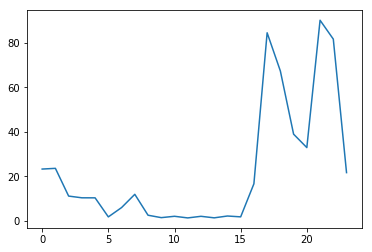

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(pred[:24, 0].data.numpy())

In [ ]:
    test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
    test_y = Variable(torch.Tensor(test_appliance), requires_grad=False)
    if cuda_av:
        test_inp = test_inp.cuda()
    pred = r(test_inp)
    #pred[pred<0.] = 0.
    pred = torch.clamp(pred, min=0.)
    if cuda_av:
        prediction_fold = pred.cpu().data.numpy()
    else:
        prediction_fold = pred.data.numpy()

In [ ]:
gts = []
preds = []

def disagg_fold(fold_num, appliance, cell_type, hidden_size,
                num_layers, bidirectional, lr,
                num_iterations):
    torch.manual_seed(0)

    appliance_num = APPLIANCE_ORDER.index(appliance)
    train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)
    train_aggregate = train[:, 0, :, :].reshape(-1, 24, 1)
    test_aggregate = test[:, 0, :, :].reshape(-1, 24, 1)

    train_appliance = train[:, appliance_num, :, :].reshape(-1, 24, 1)
    test_appliance = test[:, appliance_num, :, :].reshape(-1, 24, 1)
    gts.append(test_appliance.reshape(-1, 24))
    loss_func = nn.L1Loss()
    r = CustomRNN(cell_type, hidden_size, num_layers, bidirectional)

    if cuda_av:
        r = r.cuda()
        loss_func = loss_func.cuda()

    # Setting the params all to be non-negative
    #for param in r.parameters():
    #    param.data = param.data.abs()

    optimizer = torch.optim.Adam(r.parameters(), lr=lr)

    for t in range(num_iterations):

        inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)
        train_y = Variable(torch.Tensor(train_appliance))
        if cuda_av:
            inp = inp.cuda()
            train_y = train_y.cuda()
        pred = r(inp)

        optimizer.zero_grad()
        loss = loss_func(pred, train_y)
        if t % 5 == 0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()

    test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
    test_y = Variable(torch.Tensor(test_appliance), requires_grad=False)
    if cuda_av:
        test_inp = test_inp.cuda()
    pred = r(test_inp)
    #pred[pred<0.] = 0.
    pred = torch.clamp(pred, min=0.)
    if cuda_av:
        prediction_fold = pred.cpu().data.numpy()
    else:
        prediction_fold = pred.data.numpy()
    return prediction_fold, test_appliance

def disagg(appliance, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations):
    from sklearn.metrics import mean_absolute_error
    preds = []
    gts = []
    for cur_fold in range(num_folds):
        pred, gt = disagg_fold(cur_fold, appliance, cell_type, hidden_size, num_layers
                               ,bidirectional, lr, num_iterations)

        preds.append(pred)
        gts.append(gt)
    return mean_absolute_error(np.concatenate(gts).flatten(), np.concatenate(preds).flatten())

appliance = "hvac"
cell_type="GRU" # One of GRU, LSTM, RNN
hidden_size=100 # [20, 50, 100, 150]
num_layers=1  # [1, 2, 3, 4]
bidirectional=False # True or False
lr =1 # 1e-3, 1e-2, 1e-1, 1, 2
num_iterations = 20 #200, 400, 600, 800

appliance, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations = sys.argv[1:]
hidden_size = int(hidden_size)
num_layers = int(num_layers)
lr = float(lr)
num_iterations = int(num_iterations)

p = disagg(appliance, cell_type, hidden_size, num_layers,
                bidirectional, lr, num_iterations)

import pickle
pickle.dump(p, open("./baseline/rnn-individual-baseline-result/rnn-individual-{}-{}-{}-{}-{}-{}-{}.pkl".format(appliance,
						cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations), "wb"))